In [54]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns


In [55]:
df = pd.read_csv("iris_ds/Iris.csv", index_col = 0)

In [56]:
df['Species'][df['Species']=="Iris-setosa"] = 0
df['Species'][df['Species']=="Iris-virginica"] = 1
df['Species'][df['Species']=="Iris-versicolor"] = 2

<ipython-input-56-c53bcc4d7478>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Species'][df['Species']=="Iris-setosa"] = 0
<ipython-input-56-c53bcc4d7478>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Species'][df['Species']=="Iris-virginica"] = 1
<ipython-input-56-c53bcc4d7478>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Species'][df['Species']=="Iris-versicolor"] = 2


In [57]:
df

,SepalLengthCm,SepalWidthCm,PetalLengthCm,PetalWidthCm,Species
Id,,,,,
1,5.1,3.5,1.4,0.2,0
2,4.9,3.0,1.4,0.2,0
3,4.7,3.2,1.3,0.2,0
4,4.6,3.1,1.5,0.2,0
5,5.0,3.6,1.4,0.2,0
...,...,...,...,...,...
146,6.7,3.0,5.2,2.3,1
147,6.3,2.5,5.0,1.9,1
148,6.5,3.0,5.2,2.0,1


### Normalizacion

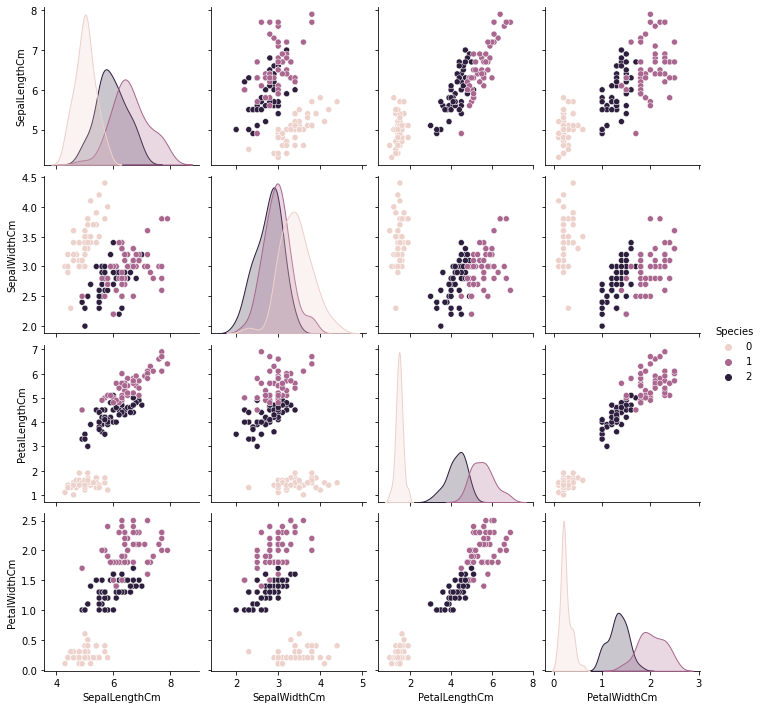

In [58]:
sns.pairplot(df, hue="Species")

In [59]:
df['SepalLengthCm'] = (df['SepalLengthCm'] - df['SepalLengthCm'].mean()) / df['SepalLengthCm'].std()
df['SepalWidthCm'] = (df['SepalWidthCm'] - df['SepalWidthCm'].mean()) / df['SepalWidthCm'].std()
df['PetalLengthCm'] = (df['PetalLengthCm'] - df['PetalLengthCm'].mean()) / df['PetalLengthCm'].std()
df['PetalWidthCm'] = (df['PetalWidthCm'] - df['PetalWidthCm'].mean()) / df['PetalWidthCm'].std()

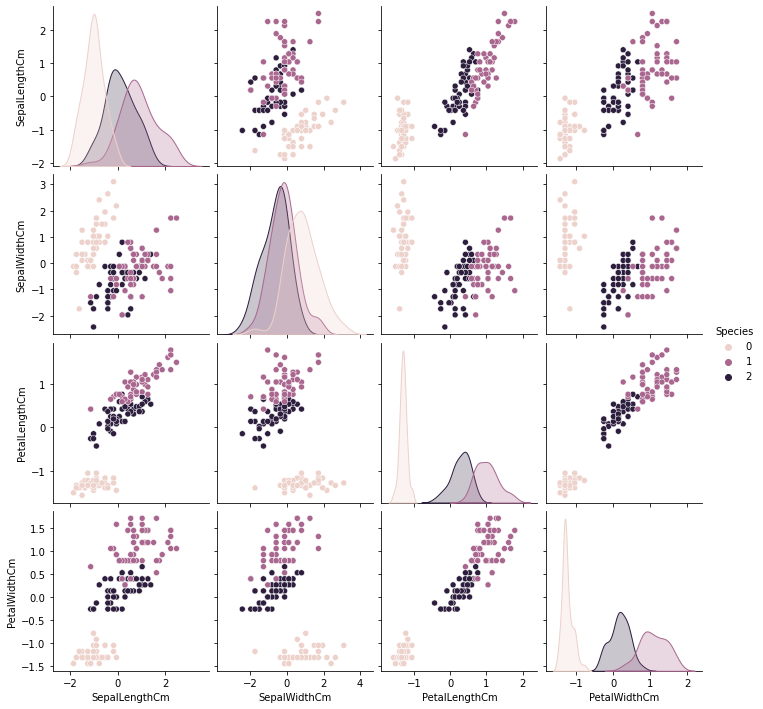

In [60]:
sns.pairplot(df, hue="Species")

### Crear dataset

In [33]:
class Dataset(torch.utils.data.Dataset):
    def __init__(self, list_IDs, dataframe):
    
        self.dataframe = dataframe
        self.list_IDs = list_IDs

    def __len__(self):

        return len(self.list_IDs)

    def __getitem__(self, index):
        
        # Select sample
        ID = self.list_IDs[index]

        # Load data and get label
        
        X = torch.tensor(list(self.dataframe.iloc[ID-1][['SepalLengthCm','SepalWidthCm',"PetalLengthCm", "PetalWidthCm"]]))
        
        y = self.dataframe.iloc[ID-1]["Species"]
        return X, y

In [34]:
size = df.index.size

In [35]:
ds = Dataset(df[:int(size*.8)].index, df)
dataloader = torch.utils.data.DataLoader(ds, batch_size=40,
                        shuffle=True)

In [36]:
ds_test = Dataset(df[-int(size*.2):].index, df)
dataloader_test = torch.utils.data.DataLoader(ds_test, batch_size=10,
                        shuffle=True)

In [37]:
for batch_inputs,batch_outputs in dataloader_test:
    print(batch_inputs)
    print(batch_outputs)
    break

tensor([[ 1.1553,  0.3367,  1.2136,  1.4431],
        [ 1.2761,  0.1061,  0.9302,  1.1811],
        [-0.0523, -0.8164,  0.7602,  0.9190],
        [ 0.0684, -0.1245,  0.7602,  0.7880],
        [ 0.5515, -0.8164,  0.6469,  0.7880],
        [ 0.5515, -1.2777,  0.7035,  0.9190],
        [ 2.4837,  1.7205,  1.4970,  1.0500],
        [ 0.7930, -0.1245,  0.8169,  1.0500],
        [ 2.2422, -0.1245,  1.3270,  1.4431],
        [ 0.5515,  0.7980,  1.0436,  1.5742]], dtype=torch.float64)
tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1])


In [71]:
epochs = 1000

model = nn.Sequential(
          nn.Linear(4,100),
          nn.ReLU(),
          nn.Linear(100,300),
          nn.ReLU(),
          nn.Linear(300,3),
          nn.Softmax()
        )

"""model = nn.Sequential(
          nn.Linear(4,1000),
          nn.ReLU(),
          nn.Linear(1000,500),
          nn.ReLU(),
          nn.Linear(500,300),
          nn.ReLU(),
          nn.Linear(300,3),
          nn.Softmax()
        )"""

loss_fn = torch.nn.CrossEntropyLoss()

loss_hist = []
loss_hist_test = []

optimizer = torch.optim.Adam(model.parameters())


for epoch in tqdm(range(1, epochs + 1)):
    
    temp = 0
    for batch_inputs,batch_outputs in dataloader_test:
        output = model(batch_inputs.float())
        loss = loss_fn(output, batch_outputs)
        temp += loss.item()
    
    loss_hist_test.append(temp)
    
    optimizer.zero_grad() # Clears existing gradients from previous epoch
    
    temp = 0
    for batch_inputs,batch_outputs in dataloader:
        
        output = model(batch_inputs.float())
        
        loss = loss_fn(output, batch_outputs)
        loss.backward() # Does backpropagation and calculates gradients
        temp += loss.item()
        optimizer.step() # Updates the weights accordingly
    
    loss_hist.append(temp)
    
    

100%|██████████| 1000/1000 [04:11<00:00,  3.97it/s]


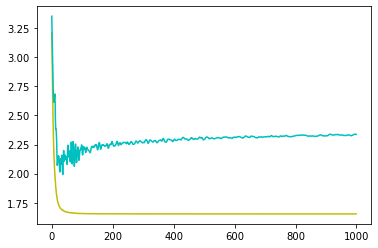

In [72]:
plt.plot(loss_hist,c="y")
plt.plot(loss_hist_test,c="c")

In [26]:
next(iv)

NameError: name 'iv' is not defined